# MACHINE LEARNING

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

In [3]:
# Load the data
american_politicians_df = pd.read_parquet('../data/american_politicians/parquet/', engine='pyarrow')
# Parse the date column to datetime
american_politicians_df['created_at'] = pd.to_datetime(american_politicians_df['created_at'])
display(american_politicians_df.head())

,author_id,id,created_at,retweet_count,reply_count,like_count,quote_count,impression_count,followers_count,following_count,tweet_count,listed_count
0,914815520842616834,1629913861737283585,2023-02-26 18:38:41+00:00,0,4,19,0,3446,97107,2211,6854,504
1,914815520842616834,1629913861737283585,2023-02-26 18:38:41+00:00,0,4,19,0,3446,97107,2211,6854,504
2,914815520842616834,1629913861737283585,2023-02-26 18:38:41+00:00,0,4,19,0,3446,97095,2211,6854,504
3,914815520842616834,1629913861737283585,2023-02-26 18:38:41+00:00,0,4,19,0,3446,97095,2211,6854,504
4,914815520842616834,1629304017087090689,2023-02-25 02:15:23+00:00,4,22,165,0,17557,97107,2211,6854,504


In [4]:
def plot_scatterplots(df, columns, x_label):
    """Plot scatterplots of the given columns against the x_label.
    
    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame to plot.
    columns : list
        The columns to plot.
    x_label : str
        The column to plot on the x-axis.
        """
    nb_rows = len(columns)
    height = 4 * nb_rows
    fig, axes = plt.subplots(nb_rows, 2, figsize=(16, height))
    colors = ['royalblue', 'dodgerblue', 'cornflowerblue', 'skyblue', 'lightsteelblue', 'lightblue', 'lightskyblue', 'powderblue']
    i = 0 

    for column in columns:
        x_label_fmt = x_label.replace('_', ' ').title()
        y_label_fmt = column.replace('_', ' ').title()

        axes = axes.flatten()
        ax1 = axes[i//2*2]
        sns.scatterplot(x=df[x_label], y=df[column], color=colors[i//2], alpha=0.5, ax=ax1)
        sns.regplot(x=df[x_label], y=df[column], color=colors[i//2], scatter=True, ax=ax1)
        ax1.set_xlabel(x_label_fmt, fontsize=8)
        ax1.set_ylabel(y_label_fmt, fontsize=8)
        ax1.set_title(f'{y_label_fmt} as a Function of {x_label_fmt} in Linear Scale', fontsize=9)
        ax1.set_xscale('linear')
        ax1.set_yscale('linear')
        
        ax2 = axes[i//2*2+(i+1)%2]
        sns.scatterplot(x=df[x_label], y=df[column], color=colors[i//2], alpha=0.5, ax=ax2)
        ax2.set_xlabel(x_label_fmt, fontsize=8)
        ax2.set_ylabel(y_label_fmt, fontsize=8)
        ax2.set_title(f'{y_label_fmt} as a Function of {x_label_fmt} in Log Scale', fontsize=9)
        ax2.set_xscale('log')
        ax2.set_yscale('log')
        
        i += 2
    plt.tight_layout()
    plt.show()

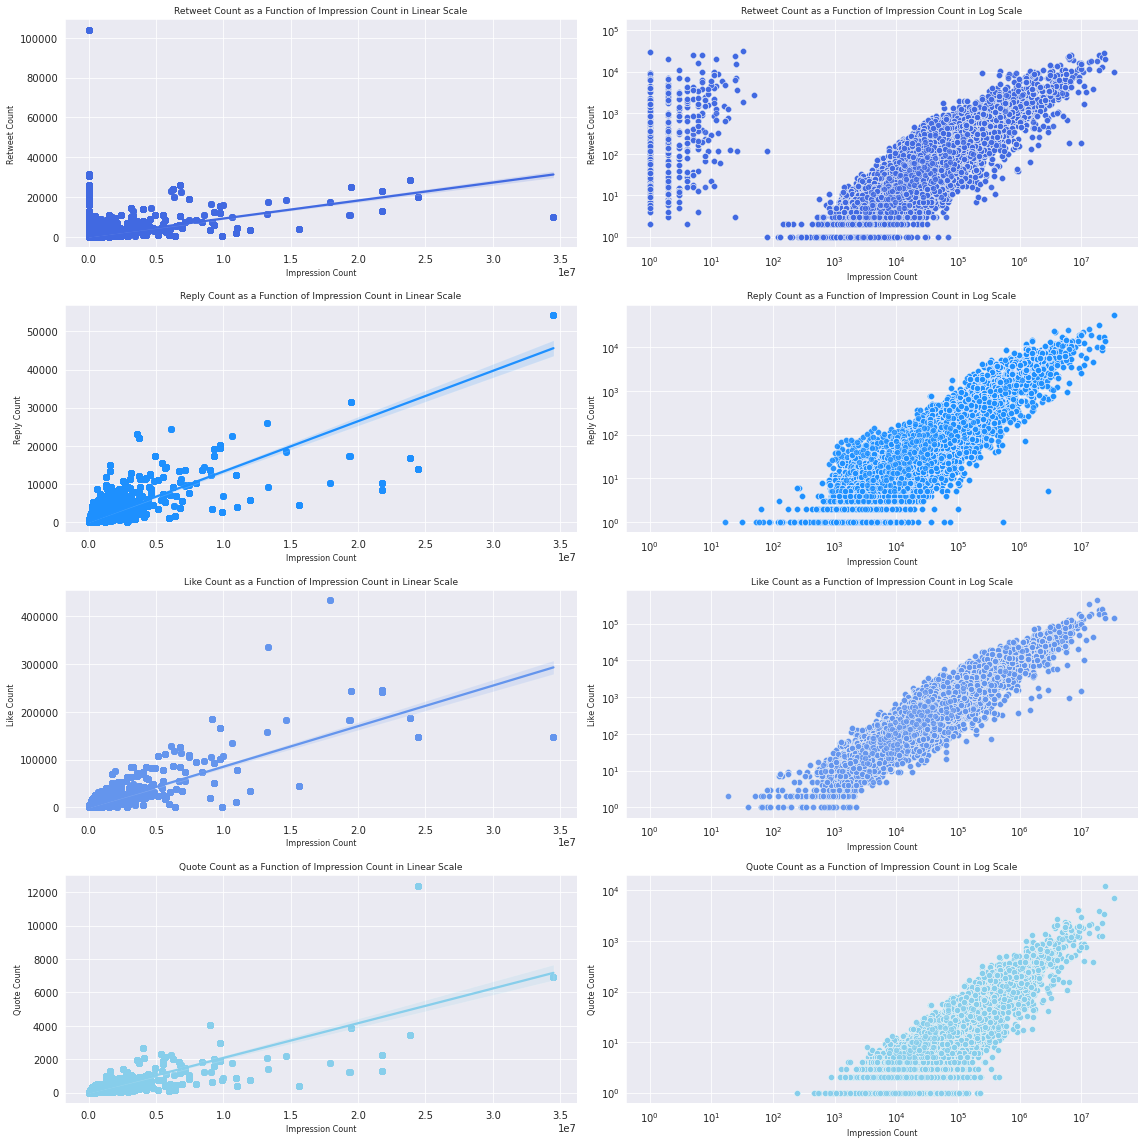

In [5]:
# Plot the scatterplots of the engagement counts against impression count
columns = ['retweet_count', 'reply_count', 'like_count', 'quote_count']
plot_scatterplots(american_politicians_df, columns, 'impression_count')

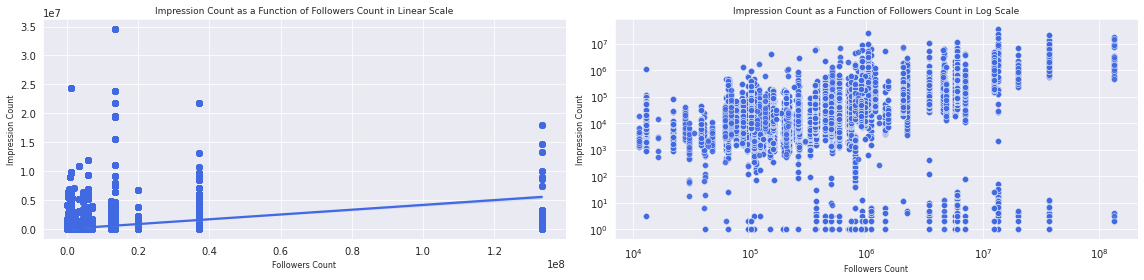

In [6]:
# Plot the scatterplots of the impression counts against follower counts
columns = ['impression_count']
plot_scatterplots(american_politicians_df, columns, 'followers_count')

### GET FEATURES FROM DATAFRAME

Tweet info:
- Tweet length  ✅
- Time of the tweet (morning, afternoon, night) ✅
- Sentiment of the tweet (score computed by model) ✅
- Number of hashtags ✅
- Number of mentions ✅
- Number of url's ✅
- Media type (video, image, text,..) => attention c un tableau
- (To clarify: location) 🚧

User info:
- Verified ✅
- Profile creation date ✅
- (To clarify: Tweet frequency) 🚧

# EXTRACTING FEATURES

In [7]:
from pyspark.sql import SparkSession
# Import spark and open json file
spark = SparkSession.builder.getOrCreate()
df = spark.read.json('../data/american_politicians/tweets.jsonl')
json_rdd = df.rdd
df.printSchema()
spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/05/02 13:58:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


root
 |-- __twarc: struct (nullable = true)
 |    |-- retrieved_at: string (nullable = true)
 |    |-- url: string (nullable = true)
 |    |-- version: string (nullable = true)
 |-- data: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- attachments: struct (nullable = true)
 |    |    |    |-- media_keys: array (nullable = true)
 |    |    |    |    |-- element: string (containsNull = true)
 |    |    |    |-- poll_ids: array (nullable = true)
 |    |    |    |    |-- element: string (containsNull = true)
 |    |    |-- author_id: string (nullable = true)
 |    |    |-- context_annotations: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- domain: struct (nullable = true)
 |    |    |    |    |    |-- description: string (nullable = true)
 |    |    |    |    |    |-- id: string (nullable = true)
 |    |    |    |    |    |-- name: string (nullable = true)
 |    |    |    |    |-- entity: str

In [8]:
json_rdd.flatMap(lambda x: x['data']).map(lambda x: {'text':x['text'],'context_annotations':x['context_annotations'], 'inner_annotations':x['entities']['annotations']}).take(10)

[{'text': 'GOOD NEWS: I’m pleased @USDOT is investing more than $1 MILLION in planning and developing a new corridor in southern West Virginia, which will expand and enhance transportation options for Bluefield area residents and visitors. MORE: https://t.co/EAciQ0Tjj8',
  'context_annotations': [Row(domain=Row(description='Entity Service top level domain, every item that is in Entity Service should be in this domain', id='30', name='Entities [Entity Service]'), entity=Row(description=None, id='781974596752842752', name='Services')),
   Row(domain=Row(description='Categories within Brand Verticals that narrow down the scope of Brands', id='46', name='Business Taxonomy'), entity=Row(description='Brands, companies, advertisers and every non-person handle with the profit intent related to Banks, Credit cards, Insurance, Investments, Stocks ', id='1557696848252391426', name='Financial Services Business')),
   Row(domain=Row(description='Products created by Brands.  Examples: Ford Explorer,

In [9]:
# Find the most common context annotations that will be used for clustering later 

annotations = json_rdd.flatMap(lambda x: x['data']).map(lambda x: x['context_annotations']).filter(lambda x: x is not None).flatMap(lambda x: list(set([y['entity']['name'] for y in x]))).map(lambda x: (x,1)).reduceByKey(lambda x,y: x+y).sortBy(lambda x: x[1], ascending=False)


In [10]:
most_frequent_annotations = annotations.filter(lambda x: x[1] > 750).collect()
# remove the first one which is 'Politics' (present in nearly all tweets)
most_frequent_annotations = list(
    map(lambda x: x[0], most_frequent_annotations))[1:]

annotation_dict = {annotation: index for index,
                   annotation in enumerate(most_frequent_annotations)}


In [11]:
annotation_dict

{'Political figures': 0,
 'Political issues': 1,
 'Joe Biden': 2,
 'United States politics': 3,
 'Government institutions': 4,
 'United States political issues': 5,
 'Jeff Merkley': 6,
 'United States Congress': 7,
 'Ted Cruz': 8,
 'North Carolina': 9,
 'Roy Cooper': 10,
 'John Cornyn': 11,
 'Financial Services Business': 12,
 'Wisconsin': 13,
 'News': 14,
 'Sports & Fitness Business': 15,
 'Richard Blumenthal': 16,
 'Global Economy': 17,
 'Debbie Stabenow': 18,
 'Ben Cardin': 19,
 'Political News': 20,
 'Business & finance': 21,
 'United States Senate': 22,
 'Lisa Murkowski': 23,
 'Chris Coons': 24,
 'Mark Warner': 25,
 'Sports': 26,
 'Chuck Schumer': 27,
 'Sheldon Whitehouse': 28,
 'Amy Klobuchar': 29,
 'Joe Manchin': 30,
 'Inflation in the United States': 31,
 'Chris Murphy': 32,
 'Seattle': 33}

In [23]:
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from datetime import datetime
import re

# Function to get the sentiment of a tweet
def analyse_sentiment(x):
    analyzer = SentimentIntensityAnalyzer()
    vs = analyzer.polarity_scores(x)
    return vs['compound']

# 
def add_key_value(x, key, value):
    x[key] = value
    return x


def keep_medias_only(x):
    urls = x['tweet_urls']
    if not urls:
        return []
    media_urls = [url['media_key'] for url in urls if 'media_key' in url and url['media_key']]
    return media_urls

def get_number_medias(x):
    return len(x['tweet_media_keys'])

def get_number_external_urls(x):
    return (len(x['tweet_urls']) if x['tweet_urls'] else 0) - x['tweet_medias_count']

def get_period_of_day(x):
    hour = datetime.strptime(x['tweet_date'],"%Y-%m-%dT%H:%M:%S.%fZ").hour
    if hour >= 6 and hour < 12:
        return 'morning'
    elif hour >= 12 and hour < 18:
        return 'afternoon'
    else:
        return 'night'


def one_hot_encoding(x, encoding_dict):
    encoding = [0] * len(encoding_dict)

    annotations = x['context_annotations']


    if not annotations:
        return encoding

    for annotation in annotations:
        # print(annotation)
        if not annotation['entity']:
            continue

        name = annotation['entity']['name']

        if name in encoding_dict:
           encoding[encoding_dict[name]] = 1

    return encoding


def add_dummy_encoding(x, column_names):
    encoding = dict(zip(column_names, x['encoded_annotations']))

    for key, value in encoding.items():

        cleaned = re.sub('[^A-Za-z0-9_]+', '', key.lower())
        cleaned = re.sub('__', '_', cleaned)

        x[f'dummy_{"_".join(cleaned.split(" "))}'] = value

    return x


def add_dummy_tweet_period(x):
    time_of_day = x['tweet_period']

    x['dummy_tweet_period_morning'] = 0
    x['dummy_tweet_period_afternoon'] = 0
    x['dummy_tweet_period_night'] = 0

    x[f'dummy_tweet_period_{time_of_day}'] = 1

    return x

In [24]:
json_rdd_data_fields =json_rdd.filter(lambda x: x['data']).flatMap(lambda x: x['data']).filter(lambda x: x['entities']) \
.map(lambda x : {
    'tweet_text': x['text'],
    'tweet_date': x['created_at'],
    'tweet_hashtags': x['entities']['hashtags'],
    'tweet_mentions': x['entities']['mentions'],
    'tweet_urls': x['entities']['urls'], 
    'user_id': x['author_id'],
    'tweet_id': x['id'],
    'context_annotations': x['context_annotations'] if x['context_annotations'] else [],
    'impression_count': x['public_metrics']['impression_count'],
    # 'retweet_count': x['public_metrics']['retweet_count'],
    # 'reply_count': x['public_metrics']['reply_count'],
    # 'like_count': x['public_metrics']['like_count'],
})


# adding sentiment analysis on the tweet text using vader to the data
json_rdd_data_fields = json_rdd_data_fields.map(lambda x : add_key_value(x, 'tweet_sentiment', analyse_sentiment(x['tweet_text'])))

# adding the tweet length to the data
json_rdd_data_fields = json_rdd_data_fields.map(lambda x : add_key_value(x, 'tweet_length', len(x['tweet_text'])))

# adding the number of hashtags to the data
json_rdd_data_fields = json_rdd_data_fields.map(lambda x : add_key_value(x, 'hashtags_count', len(x['tweet_hashtags'])if x['tweet_hashtags'] else 0))

# adding the number of mentions to the data
json_rdd_data_fields = json_rdd_data_fields.map(lambda x : add_key_value(x, 'mentions_count', len(x['tweet_mentions'])if x['tweet_mentions'] else 0))

# adding the media url's only to the data
json_rdd_data_fields = json_rdd_data_fields.map(lambda x : add_key_value(x, 'tweet_media_keys', keep_medias_only(x)))

# adding the number of medias to the data
json_rdd_data_fields = json_rdd_data_fields.map(lambda x : add_key_value(x, 'tweet_medias_count', get_number_medias(x)))

# adding the number of external urls to the data
json_rdd_data_fields = json_rdd_data_fields.map(lambda x : add_key_value(x, 'tweet_external_urls_count', get_number_external_urls(x)))

# adding the period of the day to the data
json_rdd_data_fields = json_rdd_data_fields.map(lambda x : add_key_value(x, 'tweet_period', get_period_of_day(x)))

json_rdd_data_fields = json_rdd_data_fields.map(lambda x : {k: v for k, v in x.items() if k not in ['tweet_mentions', 'tweet_urls', 'tweet_text', 'tweet_hashtags', 'tweets_media_count']})



# getting the annotations and putting them in clusters using one hot endcoding
json_rdd_data_fields = json_rdd_data_fields.map(lambda x : add_key_value(x, 'encoded_annotations', one_hot_encoding(x, annotation_dict)))


# GENERATE DUMMY VARIABLES FOR CATEGORICAL VARIABLES

# add dummy variables after one hot encoding
json_rdd_data_fields = json_rdd_data_fields.map(lambda x : add_dummy_encoding(x, most_frequent_annotations))

json_rdd_data_fields = json_rdd_data_fields.map(lambda x : add_dummy_tweet_period(x))

# 2. Create a dataframe from the rdd

# transforming the data to a dataframe
regression_df = json_rdd_data_fields.toDF().drop('context_annotations','encoded_annotations','tweet_date','tweet_media_keys','tweet_period').persist()


# getting the followers count data
json_rdd_followers = json_rdd.filter(lambda x: x['includes'] and x['data'] and x['includes']['users']).map(lambda x: {
    'followers_count': x['includes']['users'][0]['public_metrics']['followers_count'], 
    'user_id': x['includes']['users'][0]['id']})

# converting the rdd to a dataframe
json_followers_df = json_rdd_followers.toDF()
json_followers_df = json_followers_df.dropDuplicates(['user_id'])

# 4. Join the two dataframes in order to get the media type for each tweet.
# If a tweet has multiple media, we will get multiple rows for the same tweet id in the exploded dataframe
# Then when performing the join, we will have a set of media types for each tweet id in the json_medias_per_tweet_df dataframe

regression_df = regression_df.join(
json_followers_df, on='user_id',how='inner').drop('user_id','tweet_id').persist()


In [25]:
regression_df_pd = regression_df.toPandas()

In [26]:
regression_df_pd.to_csv('regression_df.csv', index=False)


In [27]:
regressor_columns = list(filter(lambda x: x != 'impression_count',regression_df_pd.columns))
regressor_columns_string = "+".join(regressor_columns)
regressor_columns

['dummy_amyklobuchar',
 'dummy_bencardin',
 'dummy_businessfinance',
 'dummy_chriscoons',
 'dummy_chrismurphy',
 'dummy_chuckschumer',
 'dummy_debbiestabenow',
 'dummy_financialservicesbusiness',
 'dummy_globaleconomy',
 'dummy_governmentinstitutions',
 'dummy_inflationintheunitedstates',
 'dummy_jeffmerkley',
 'dummy_joebiden',
 'dummy_joemanchin',
 'dummy_johncornyn',
 'dummy_lisamurkowski',
 'dummy_markwarner',
 'dummy_news',
 'dummy_northcarolina',
 'dummy_politicalfigures',
 'dummy_politicalissues',
 'dummy_politicalnews',
 'dummy_richardblumenthal',
 'dummy_roycooper',
 'dummy_seattle',
 'dummy_sheldonwhitehouse',
 'dummy_sports',
 'dummy_sportsfitnessbusiness',
 'dummy_tedcruz',
 'dummy_tweet_period_afternoon',
 'dummy_tweet_period_morning',
 'dummy_tweet_period_night',
 'dummy_unitedstatescongress',
 'dummy_unitedstatespoliticalissues',
 'dummy_unitedstatespolitics',
 'dummy_unitedstatessenate',
 'dummy_wisconsin',
 'hashtags_count',
 'mentions_count',
 'tweet_external_urls_cou

In [28]:
# normalize the data (remove mean and divide by standard deviation) except the dummy variables

# extract all columns except dummy variables

regression_df_pd[regressor_columns] = regression_df_pd[regressor_columns].apply(lambda x: (x - x.mean()) / x.std())

In [29]:
regression_df_pd

,dummy_amyklobuchar,dummy_bencardin,dummy_businessfinance,dummy_chriscoons,dummy_chrismurphy,dummy_chuckschumer,dummy_debbiestabenow,dummy_financialservicesbusiness,dummy_globaleconomy,dummy_governmentinstitutions,...,dummy_unitedstatessenate,dummy_wisconsin,hashtags_count,impression_count,mentions_count,tweet_external_urls_count,tweet_length,tweet_medias_count,tweet_sentiment,followers_count
0,-0.136934,-0.149573,-0.146598,-0.143567,-0.138476,-0.14532,-0.150996,-0.179724,-0.155711,-0.26335,...,-0.14993,-0.16826,-0.382113,3446,-0.668633,-0.711186,-2.351334,0.641288,-0.558735,-0.223509
1,-0.136934,-0.149573,-0.146598,-0.143567,-0.138476,-0.14532,-0.150996,-0.179724,-0.155711,-0.26335,...,-0.14993,-0.16826,1.492367,17557,-0.668633,-0.711186,-0.570521,0.641288,-0.558735,-0.223509
2,-0.136934,-0.149573,-0.146598,-0.143567,-0.138476,-0.14532,-0.150996,-0.179724,-0.155711,-0.26335,...,-0.14993,-0.16826,-0.382113,3358,-0.668633,1.320321,-1.052545,0.641288,0.447497,-0.223509
3,-0.136934,-0.149573,-0.146598,-0.143567,-0.138476,-0.14532,-0.150996,-0.179724,-0.155711,-0.26335,...,-0.14993,-0.16826,-0.382113,7054,0.410232,-0.711186,-1.829140,1.823719,-0.558735,-0.223509
4,-0.136934,-0.149573,-0.146598,-0.143567,-0.138476,-0.14532,-0.150996,-0.179724,-0.155711,-0.26335,...,-0.14993,-0.16826,-0.382113,12243,-0.668633,-0.711186,0.781826,0.641288,0.961677,-0.223509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39112,-0.136934,-0.149573,-0.146598,-0.143567,-0.138476,-0.14532,-0.150996,-0.179724,-0.155711,-0.26335,...,-0.14993,-0.16826,1.492367,6860,-0.668633,1.320321,1.183513,-0.541143,0.922253,-0.224946
39113,-0.136934,-0.149573,-0.146598,-0.143567,-0.138476,-0.14532,-0.150996,-0.179724,-0.155711,-0.26335,...,-0.14993,-0.16826,1.492367,4380,-0.668633,-0.711186,0.460476,-0.541143,1.032156,-0.224946
39114,-0.136934,-0.149573,-0.146598,-0.143567,-0.138476,-0.14532,-0.150996,-0.179724,-0.155711,-0.26335,...,-0.14993,-0.16826,1.492367,7925,-0.668633,-0.711186,0.741657,-0.541143,1.079018,-0.224946
39115,-0.136934,-0.149573,-0.146598,-0.143567,-0.138476,-0.14532,-0.150996,-0.179724,-0.155711,-0.26335,...,-0.14993,-0.16826,1.492367,13628,0.410232,-0.711186,1.063007,0.641288,0.922253,-0.224946


In [30]:
# ols regression follower count on the other variables
import statsmodels.formula.api as smf
mod = smf.ols(formula=f'impression_count ~ {regressor_columns_string}', data=regression_df_pd)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:       impression_count   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     125.8
Date:                Tue, 02 May 2023   Prob (F-statistic):               0.00
Time:                        14:29:35   Log-Likelihood:            -5.7808e+05
No. Observations:               39117   AIC:                         1.156e+06
Df Residuals:                   39073   BIC:                         1.157e+06
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

In [19]:
json_rdd_includes_fields =json_rdd \
.map(lambda x : {
    'user_profile_creation_date': x['includes']['users'][0]['created_at'],
    'user_verified': x['includes']['users'][0]['verified'],
    'user_creation_date': x['includes']['users'][0]['created_at'],
    'user_id': x['includes']['users'][0]['id'],
})

json_inclued_fields_df = json_rdd_includes_fields.toDF(['user_profile_creation_date', 'user_verified', 'user_creation_date', 'user_id'])

json_inclued_fields_df.count()

618